# Detecting Tomato plant diseases

In this notebook we present two possible solutions for detecting plant diseases using two well known Deep Neural Network architectures: 

*  **VGG**
*   **ResNet**

The dataset that we are using further in this notebook is the well known open source repository  of plant leaves images [PlantVillage](https://github.com/spMohanty/PlantVillage-Dataset/tree/master/raw). There are total of 14 plants with few of their diseases making total of 38 [plant, disease] pairs. For this research we are using only 10 of those clases, more precisely the 10 classes that corespond to tomato plants. The classes that we use are:

1.   Bacterial Spot
2.   Early Blight
3.   Late Blight
4.   Leaf Mold
5.   Septoria Leaf Spot
6.   Spider Mites Two-spotted Spider Mite
7.   Target_Spot
8.   Tomato Mosaic Virus
9.   Tomato Yellow Leaf Curl Virus
10. Healthy





### Prepearing the data source
We are using google drive to access and use the data. Here, we mount the drive and unzip the data for further use.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import os 
sets = ['train', 'test', 'validation']
counts = dict()

for s in sets:
  root = '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/{}'.format(s)
  for d in os.listdir(root):
    directory = '{}/{}'.format(root, d)
    number_of_files = len(os.listdir(directory))
    counts.setdefault(d, 0)
    counts[d] += number_of_files

for f, c in counts.items():
  print(f, '->' ,c)

Tomato___Bacterial_spot -> 2127
Tomato___Early_blight -> 1000
Tomato___healthy -> 1591
Tomato___Late_blight -> 1909
Tomato___Leaf_Mold -> 952
Tomato___Septoria_leaf_spot -> 1771
Tomato___Spider_mites Two-spotted_spider_mite -> 1676
Tomato___Target_Spot -> 1404
Tomato___Tomato_mosaic_virus -> 373
Tomato___Tomato_Yellow_Leaf_Curl_Virus -> 5332


In [0]:
get_ipython().system_raw("unrar x datasets.rar")

### Imports
We are using Keras with TensorFlow backend.

In [0]:
import os
import numpy as np
import cv2
import random

In [0]:
from keras import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import vgg16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input as vgg_pi
from keras.applications.resnet50 import preprocess_input as resnet_pi
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import keras

Using TensorFlow backend.


### Training and testing the models

Next we train and test these two model architectures: VGG and ResNet. Our goal is to see which of the two models is better on the chosen dataset and whether it's better to use the models pretrained on imagenet or using them plain, only trained on the PlantVillage dataset. 


Each of the two models has been trained and tested four times:
1. **Plain**  - base was untrained, model was completely trained on PlantVillage
2. **Pretrained** - base was pretrained on imagenet, model was fine-tuned on PlantVillage
3. **Pretrained (l2)** - introducing Ridge regularization on model 2
4. **Pretrained (dropout)** - introducing dropout layer on model 2

Following is the code to train each model, while testing and results are available in model_overview.ipynb

# VGG

We are using the Keras implementation of VGG with 16 layers. The input tensor has a shape of (224, 224, 3).  
To avoid overflowing the RAM we use ImageDataGenerator. Another nifty feature of the generator is that it can apply transformations to the images (rotation, flip, shear...) on the go in order to avoid overfitting the models. 

## Plain

In [0]:
base_model = vgg16.VGG16(include_top=False,
                         input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = True
# base_model.summary()

In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dense(10, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0614 10:37:37.222698 139863647811456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
# check if GPU is running
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# do not rerun
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=100, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

W0614 10:38:29.766515 139863647811456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


362/362 [==============================] - 1611s 4s/step - loss: 11.3656 - acc: 0.2927 - val_loss: 11.5737 - val_acc: 0.2819
Epoch 2/100
362/362 [==============================] - 1530s 4s/step - loss: 11.4708 - acc: 0.2883 - val_loss: 11.6408 - val_acc: 0.2778
Epoch 3/100
362/362 [==============================] - 1554s 4s/step - loss: 11.3845 - acc: 0.2937 - val_loss: 11.1931 - val_acc: 0.3056
Epoch 4/100
362/362 [==============================] - 1564s 4s/step - loss: 11.2064 - acc: 0.3047 - val_loss: 11.4618 - val_acc: 0.2889
Epoch 5/100
362/362 [==============================] - 181s 499ms/step - loss: 11.0691 - acc: 0.3132 - val_loss: 11.7974 - val_acc: 0.2681
Epoch 6/100
362/362 [==============================] - 174s 480ms/step - loss: 11.5181 - acc: 0.2854 - val_loss: 11.2491 - val_acc: 0.3021
Epoch 7/100
362/362 [==============================] - 174s 480ms/step - loss: 11.4263 - acc: 0.2911 - val_loss: 11.2939 - val_acc: 0.2993
Epoch 8/100
362/362 [==========================

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/vgg_untrained.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/vgg_untrained.h5')

In [0]:
import matplotlib.pyplot as plt

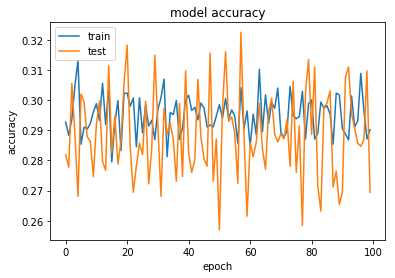

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

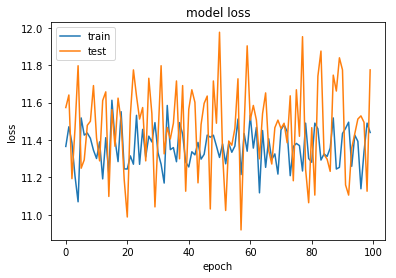

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Pretrain-ImageNet

In [0]:
base_model = vgg16.VGG16(include_top=False, weights='imagenet',
                         input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False
# base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dense(10, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
# check if GPU is running
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# do not rerun
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=100, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


362/362 [==============================] - 1144s 3s/step - loss: 1.4872 - acc: 0.6553 - val_loss: 1.1786 - val_acc: 0.7222
Epoch 2/100
362/362 [==============================] - 1112s 3s/step - loss: 1.0711 - acc: 0.7318 - val_loss: 0.8970 - val_acc: 0.7708
Epoch 3/100
362/362 [==============================] - 1149s 3s/step - loss: 1.1420 - acc: 0.7573 - val_loss: 1.3682 - val_acc: 0.7160
Epoch 4/100
362/362 [==============================] - 1119s 3s/step - loss: 1.2713 - acc: 0.7490 - val_loss: 1.1203 - val_acc: 0.7667
Epoch 5/100
362/362 [==============================] - 143s 395ms/step - loss: 0.6451 - acc: 0.8431 - val_loss: 0.7655 - val_acc: 0.8179
Epoch 6/100
362/362 [==============================] - 135s 372ms/step - loss: 0.5465 - acc: 0.8649 - val_loss: 1.5304 - val_acc: 0.7229
Epoch 7/100
362/362 [==============================] - 134s 370ms/step - loss: 0.3654 - acc: 0.9053 - val_loss: 0.7551 - val_acc: 0.8226
Epoch 8/100
362/362 [==============================] - 133s 3

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/vgg_imagenet.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/vgg_imagenet.h5')

In [0]:
import matplotlib.pyplot as plt

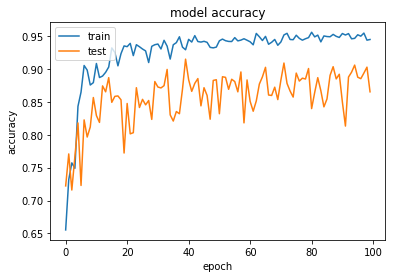

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

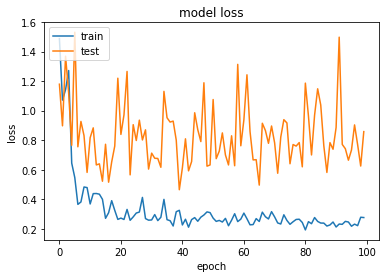

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###  Pretrain-ImageNet (L2 regularization)

In [0]:
base_model = vgg16.VGG16(include_top=False, weights='imagenet',
                         input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False
# base_model.summary()

In [0]:
from keras.regularizers import l2

In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dense(10, kernel_regularizer=l2(0.01), activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
# do not rerun if you already have these in RAM

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
# check if GPU is running
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=100, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
362/362 [==============================] - 143s 396ms/step - loss: 1.5595 - acc: 0.6626 - val_loss: 1.5320 - val_acc: 0.6764
Epoch 2/100
362/362 [==============================] - 138s 380ms/step - loss: 1.0505 - acc: 0.8166 - val_loss: 1.0412 - val_acc: 0.7892
Epoch 3/100
362/362 [==============================] - 138s 381ms/step - loss: 1.0020 - acc: 0.8182 - val_loss: 1.2565 - val_acc: 0.7233
Epoch 4/100
362/362 [==============================] - 137s 379ms/step - loss: 0.8127 - acc: 0.8693 - val_loss: 1.1019 - val_acc: 0.7479
Epoch 5/100
362/362 [==============================] - 137s 378ms/step - loss: 0.7289 - acc: 0.8778 - val_loss: 1.0928 - val_acc: 0.7761
Epoch 6/100
362/362 [==============================] - 137s 379ms/step - loss: 0.8820 - acc: 0.8414 - val_loss: 0.9427 - val_acc: 0.8031
Epoch 7/100
362/362 [==============================] - 137s 377ms/step - loss: 0.7078 - acc: 0.8865 - val_loss: 1.3551 - val_acc: 0.7347
Epoch 8/100
362/362 [====================

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/vgg_imagenet_l2.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/vgg_imagenet_l2.h5')

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/domat/history/vgg_imagenet_l2.pickle', 'rb') as handle:
    history = pickle.load(handle)
    

W0614 04:26:02.549777 140474340210560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 04:26:02.586210 140474340210560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 04:26:02.623510 140474340210560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0614 04:26:02.836492 140474340210560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0614 04:26:02.838206 140474340210560 deprecation_

In [0]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/domat/models/vgg_imagenet_l2.h5')

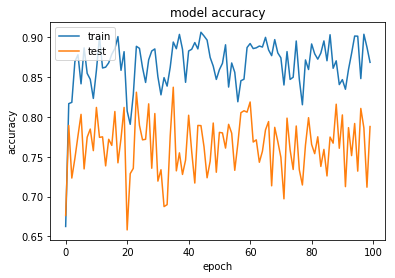

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

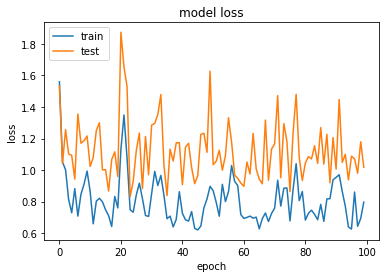

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Pretrain-ImageNet (Dropout)

In [0]:
base_model = vgg16.VGG16(include_top=False, weights='imagenet',
                         input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False
# base_model.summary()

W0614 04:32:56.325140 139842819327872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 04:32:56.367103 139842819327872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 04:32:56.376504 139842819327872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 04:32:56.414886 139842819327872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 4s 0us/step


W0614 04:33:01.425774 139842819327872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0614 04:33:01.426788 139842819327872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0614 04:36:36.748822 139842819327872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
# check if GPU is running
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# do not rerun
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=100, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

W0614 04:37:46.055070 139842819327872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


362/362 [==============================] - 2125s 6s/step - loss: 1.8313 - acc: 0.6086 - val_loss: 1.5646 - val_acc: 0.7167
Epoch 2/100
362/362 [==============================] - 1967s 5s/step - loss: 1.9689 - acc: 0.6650 - val_loss: 1.9849 - val_acc: 0.6910
Epoch 3/100
362/362 [==============================] - 1982s 5s/step - loss: 1.9016 - acc: 0.6916 - val_loss: 1.5910 - val_acc: 0.7444
Epoch 4/100
362/362 [==============================] - 1972s 5s/step - loss: 1.9668 - acc: 0.6996 - val_loss: 1.9973 - val_acc: 0.7097
Epoch 5/100
362/362 [==============================] - 135s 373ms/step - loss: 1.5840 - acc: 0.7567 - val_loss: 1.4777 - val_acc: 0.7688
Epoch 6/100
362/362 [==============================] - 133s 369ms/step - loss: 1.4781 - acc: 0.7742 - val_loss: 1.1753 - val_acc: 0.8247
Epoch 7/100
362/362 [==============================] - 135s 373ms/step - loss: 1.0830 - acc: 0.8001 - val_loss: 0.8354 - val_acc: 0.8073
Epoch 8/100
362/362 [==============================] - 136s 3

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/vgg_imagenet_dropout.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/vgg_imagenet_dropout.h5')

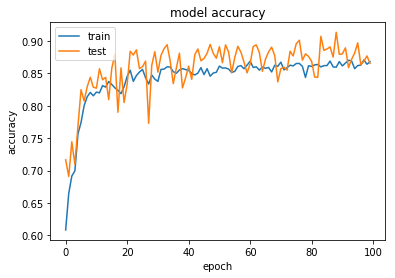

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

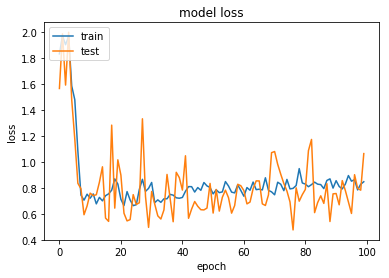

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ResNet

We are using the Keras implementation of ResNet with 50 layers. The input tensor also has a shape of (224, 224, 3). 
We use ImageDataGenerator here as well.

## Plain

In [0]:
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = True
# base_model.summary()

W0617 23:15:26.485664 140037536708480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 23:15:26.525398 140037536708480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 23:15:26.535340 140037536708480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0617 23:15:26.571587 140037536708480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 23:15:26.572413

94658560/94653016 [==============================] - 6s 0us/step


In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dense(10, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0617 23:15:52.594953 140037536708480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# do not rerun
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=50, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

W0617 23:17:07.277194 140037536708480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


362/362 [==============================] - 2082s 6s/step - loss: 1.4482 - acc: 0.6361 - val_loss: 3.0035 - val_acc: 0.5069
Epoch 2/50
362/362 [==============================] - 1976s 5s/step - loss: 0.9991 - acc: 0.6932 - val_loss: 10.6612 - val_acc: 0.2472
Epoch 3/50
362/362 [==============================] - 2016s 6s/step - loss: 0.8597 - acc: 0.7195 - val_loss: 1.5737 - val_acc: 0.6840
Epoch 4/50
362/362 [==============================] - 1978s 5s/step - loss: 0.7534 - acc: 0.7541 - val_loss: 1.8180 - val_acc: 0.5687
Epoch 5/50
362/362 [==============================] - 176s 487ms/step - loss: 0.6022 - acc: 0.8034 - val_loss: 1.0606 - val_acc: 0.7305
Epoch 6/50
362/362 [==============================] - 173s 479ms/step - loss: 0.5968 - acc: 0.8149 - val_loss: 11.3946 - val_acc: 0.2931
Epoch 7/50
362/362 [==============================] - 172s 476ms/step - loss: 1.0835 - acc: 0.7264 - val_loss: 1.9960 - val_acc: 0.5250
Epoch 8/50
362/362 [==============================] - 172s 475ms/

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/resnet_untrained.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/resnet_untrained.h5')

In [0]:
import matplotlib.pyplot as plt

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/domat/history/resnet_untrained.pickle', 'rb') as handle:
    history = pickle.load(handle)
   

In [0]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/domat/models/resnet_untrained.h5')

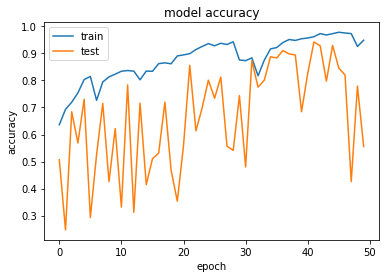

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

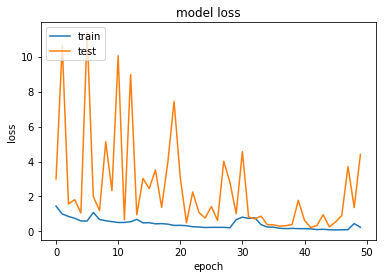

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Pretrain-ImageNet

In [0]:
base_model = ResNet50(include_top=False, weights='imagenet',
                         input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
# base_model.summary()

W0618 07:21:58.520182 139705968113536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 07:21:58.572934 139705968113536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 07:21:58.584466 139705968113536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0618 07:21:58.619144 139705968113536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 07:21:58.620147

94658560/94653016 [==============================] - 3s 0us/step


In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dense(10, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0618 07:22:18.220149 139705968113536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# do not rerun
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=50, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

W0618 07:23:24.566237 139705968113536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


362/362 [==============================] - 1213s 3s/step - loss: 8.5446 - acc: 0.4622 - val_loss: 11.5641 - val_acc: 0.2819
Epoch 2/50
362/362 [==============================] - 1131s 3s/step - loss: 7.7206 - acc: 0.5171 - val_loss: 11.7113 - val_acc: 0.1347
Epoch 3/50
362/362 [==============================] - 1166s 3s/step - loss: 6.2197 - acc: 0.6099 - val_loss: 11.3946 - val_acc: 0.2931
Epoch 4/50
362/362 [==============================] - 1163s 3s/step - loss: 5.7921 - acc: 0.6371 - val_loss: 11.4394 - val_acc: 0.2903
Epoch 5/50
362/362 [==============================] - 142s 393ms/step - loss: 5.6316 - acc: 0.6470 - val_loss: 11.4364 - val_acc: 0.2905
Epoch 6/50
362/362 [==============================] - 142s 392ms/step - loss: 5.6020 - acc: 0.6493 - val_loss: 11.4114 - val_acc: 0.2920
Epoch 7/50
362/362 [==============================] - 141s 389ms/step - loss: 5.6338 - acc: 0.6481 - val_loss: 11.4897 - val_acc: 0.2872
Epoch 8/50
362/362 [==============================] - 142s 3

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/resnet_imagenet.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/resnet_imagenet.h5')

In [0]:
import matplotlib.pyplot as plt

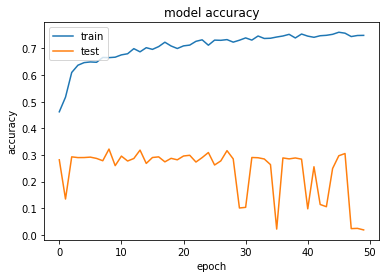

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

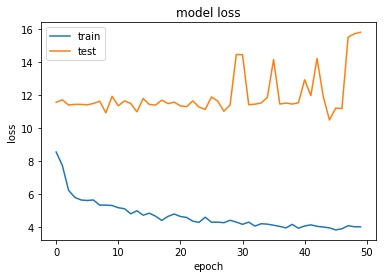

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Pretrain-ImageNet (L2 regularization)

In [0]:
base_model = ResNet50(include_top=False, weights='imagenet',
                         input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
# base_model.summary()

W0618 10:57:43.382792 139867013502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 10:57:43.434095 139867013502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 10:57:43.445069 139867013502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0618 10:57:43.491618 139867013502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 10:57:43.492614

94658560/94653016 [==============================] - 8s 0us/step


In [0]:
from keras.regularizers import l2

In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dense(10, kernel_regularizer=l2(0.01), activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0618 10:58:39.155682 139867013502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# do not rerun
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=50, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

W0618 10:59:38.448576 139867013502848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


362/362 [==============================] - 1841s 5s/step - loss: 12.2247 - acc: 0.2610 - val_loss: 15.0905 - val_acc: 0.0806
Epoch 2/50
362/362 [==============================] - 1713s 5s/step - loss: 12.4824 - acc: 0.2538 - val_loss: 14.8424 - val_acc: 0.1076
Epoch 3/50
362/362 [==============================] - 1733s 5s/step - loss: 10.8182 - acc: 0.3696 - val_loss: 13.0904 - val_acc: 0.2583
Epoch 4/50
362/362 [==============================] - 1710s 5s/step - loss: 8.6964 - acc: 0.5283 - val_loss: 13.1255 - val_acc: 0.2889
Epoch 5/50
362/362 [==============================] - 156s 432ms/step - loss: 8.6680 - acc: 0.5371 - val_loss: 13.0980 - val_acc: 0.2688
Epoch 6/50
362/362 [==============================] - 152s 419ms/step - loss: 8.4012 - acc: 0.5523 - val_loss: 12.2947 - val_acc: 0.3028
Epoch 7/50
362/362 [==============================] - 154s 426ms/step - loss: 8.4229 - acc: 0.5413 - val_loss: 12.4139 - val_acc: 0.3028
Epoch 8/50
362/362 [==============================] - 151

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/resnet_imagenet_l2.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/resnet_imagenet_l2.h5')

In [0]:
import matplotlib.pyplot as plt

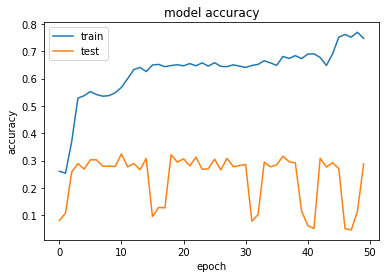

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

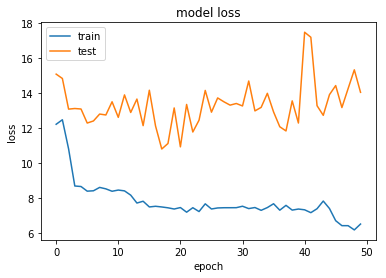

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Pretrain-ImageNet (Dropout)

In [0]:
base_model = ResNet50(include_top=False, weights='imagenet',
                         input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
# base_model.summary()

W0618 20:57:17.292350 140413427971968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 20:57:17.341349 140413427971968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 20:57:17.351031 140413427971968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0618 20:57:17.386530 140413427971968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 20:57:17.388871

94658560/94653016 [==============================] - 8s 0us/step


In [0]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary() # 1M trainable params...

W0618 20:57:55.752761 140413427971968 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0618 20:58:00.424947 140413427971968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/train/', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/domat/solo-dataset/validation/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
)

Found 11614 images belonging to 10 classes.
Found 2884 images belonging to 10 classes.


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# do not rerun
t_steps = 11614 // 32
v_steps = 2884 // 32
history = model.fit_generator(train_generator, 
                              epochs=50, 
                              workers = 4,
                              use_multiprocessing=True,
                              steps_per_epoch=t_steps, 
                              validation_data=validation_generator,
                              validation_steps=v_steps,
                             )

W0618 21:02:36.694247 140413427971968 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


362/362 [==============================] - 1739s 5s/step - loss: 6.9200 - acc: 0.5518 - val_loss: 12.3267 - val_acc: 0.0938
Epoch 2/50
362/362 [==============================] - 1652s 5s/step - loss: 6.7331 - acc: 0.5735 - val_loss: 10.9620 - val_acc: 0.3076
Epoch 3/50
362/362 [==============================] - 1672s 5s/step - loss: 6.1559 - acc: 0.6092 - val_loss: 14.6350 - val_acc: 0.0729
Epoch 4/50
362/362 [==============================] - 1679s 5s/step - loss: 5.4194 - acc: 0.6558 - val_loss: 14.5616 - val_acc: 0.0965
Epoch 5/50
362/362 [==============================] - 145s 401ms/step - loss: 5.1164 - acc: 0.6751 - val_loss: 14.7089 - val_acc: 0.0874
Epoch 6/50
362/362 [==============================] - 144s 399ms/step - loss: 5.1170 - acc: 0.6763 - val_loss: 14.2488 - val_acc: 0.1160
Epoch 7/50
362/362 [==============================] - 145s 402ms/step - loss: 5.1786 - acc: 0.6728 - val_loss: 14.5399 - val_acc: 0.0979
Epoch 8/50
362/362 [==============================] - 143s 3

In [0]:
# save history object
import pickle

with open('/content/drive/My Drive/Colab Notebooks/domat/history/resnet_imagenet_dropout.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# save trained model
model.save('/content/drive/My Drive/Colab Notebooks/domat/models/resnet_imagenet_dropout.h5')

In [0]:
import matplotlib.pyplot as plt

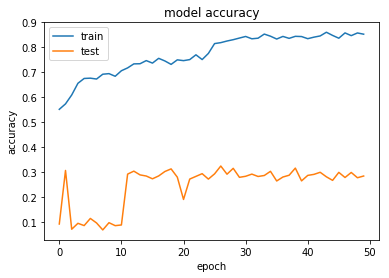

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

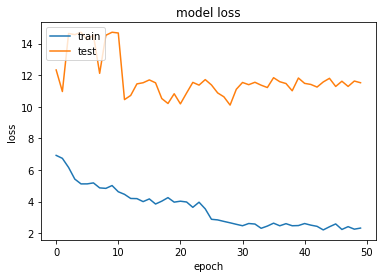

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()